# A Time-Series for Modeling Tairua Beach Shoreline

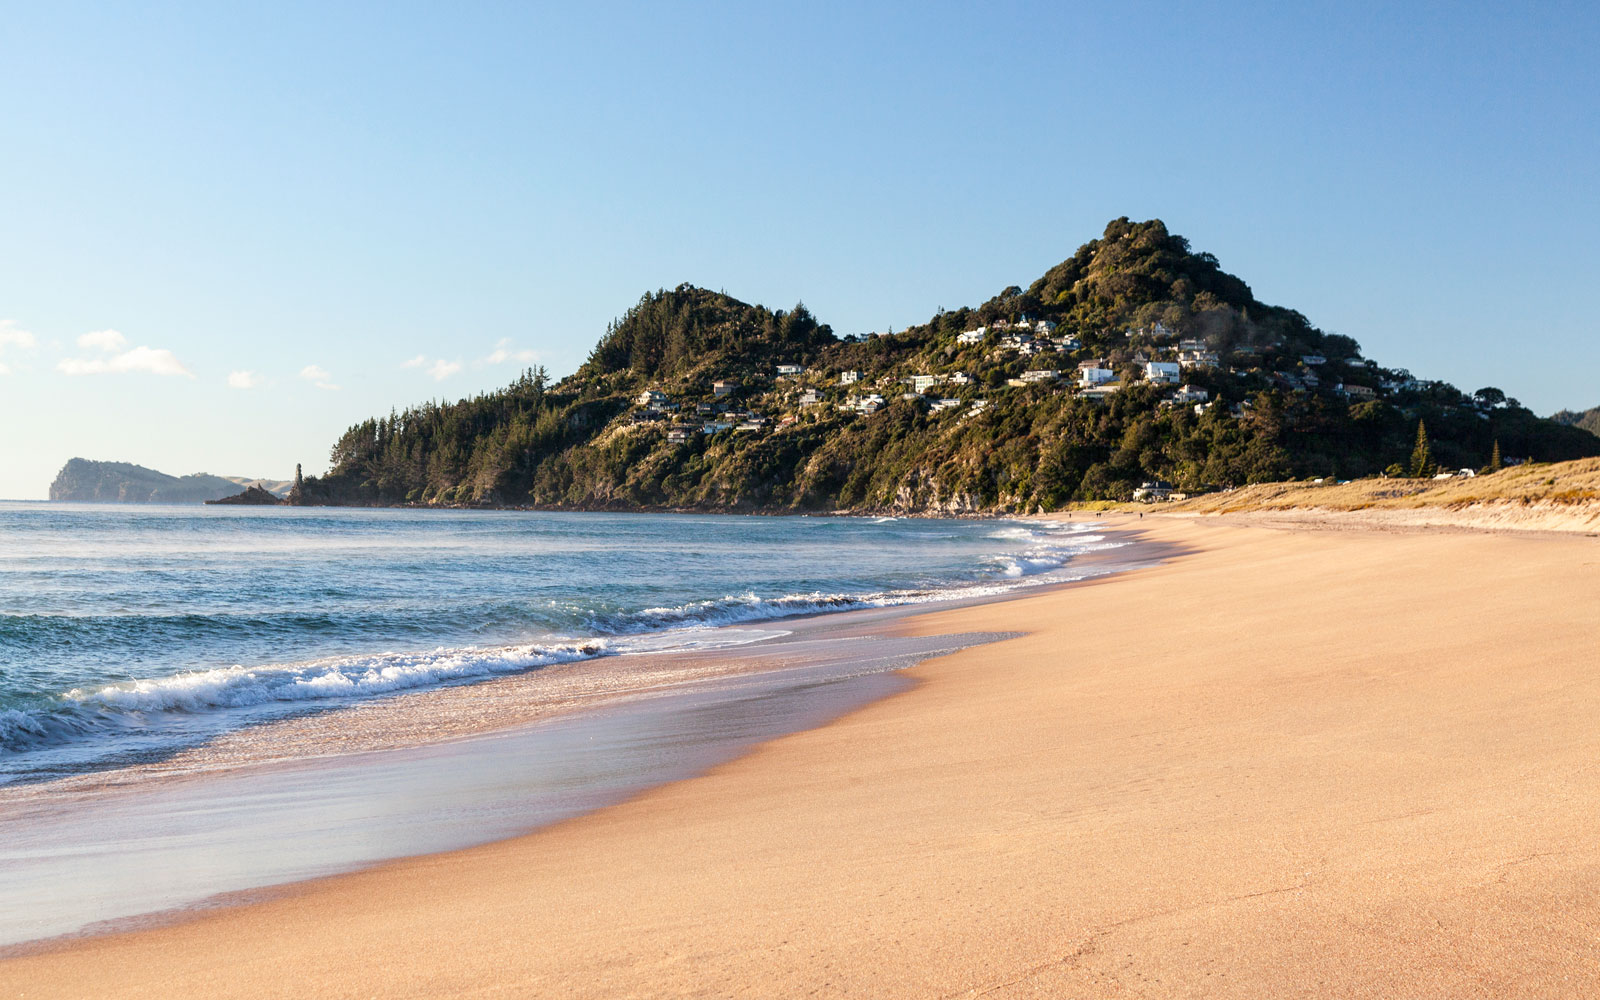

**In this project, I will make an attemp to build a Time-Series model to predict the [Tairua Beach](https://www.findabeach.co.nz/beaches/tairua/about/) (located in New Zealand) shoreline. For this, I will be using a 15-year (1999 - 2013, inclusive) of daily data of the shoreline location in meters from a datum (i.e. the width of the beach, available [here](https://github.com/arashshams/Shoreline-Time-Series/tree/master/Data/Raw)) and predict the monthly shoreline location for the next 3 years (2014 - 2016, inclusive). The predictions are later compared with true observations (found [here](https://github.com/arashshams/Shoreline-Time-Series/tree/master/Data/Raw)).**

**The idea for this work stems from a modeling competition (The M4 Competition) where you can find more about in the paper by Makridakis et al. found [here](https://www.sciencedirect.com/science/article/pii/S0169207019301128#!).**

In [1]:
# Necessary Imports

import numpy as np
import pandas as pd
import numbers
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ETSModel, SimpleExpSmoothing, seasonal_decompose, Holt
from statsmodels.tsa.arima.model import ARIMA
#from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import plotly.express as px
import matplotlib as mpl
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Reading in the data

Firts, let's read the data in.

In [2]:
# Reading in the data and parsing dates into datetimes
beach_data = pd.read_csv("../input/beachdata/beach-train.csv", index_col=0, parse_dates=True)
beach_data

,Shoreline
Time,
1999-01-02,56.400000
1999-01-03,57.673000
1999-01-04,58.593333
1999-01-05,56.454500
1999-01-06,61.905000
...,...
2013-12-27,NaN
2013-12-28,65.977000
2013-12-29,61.821000


We have a total of 5478 observations of the shoreline (i.e. beach width). I will be build and train the model based on these data.

But first, let's do some data cleaning.

## Data Cleaning

In [3]:
# Resampling the data to a monthly resolution and aggregating observations by the mean
beach_data = beach_data.resample('M', kind="timestamp").mean()
beach_data

,Shoreline
Time,
1999-01-31,57.509911
1999-02-28,56.589458
1999-03-31,57.779581
1999-04-30,59.224900
1999-05-31,62.658231
...,...
2013-08-31,61.593417
2013-09-30,61.720667
2013-10-31,65.567900


In [4]:
# Printing the number of missing values -----> Checked
print("The number of missing values in the re-sampled data is:", beach_data["Shoreline"].isnull().sum())

The number of missing values in the re-sampled data is: 0


## Plotting the Data

Now, let's plot the shoreline vs time to see how the data trend looks like.

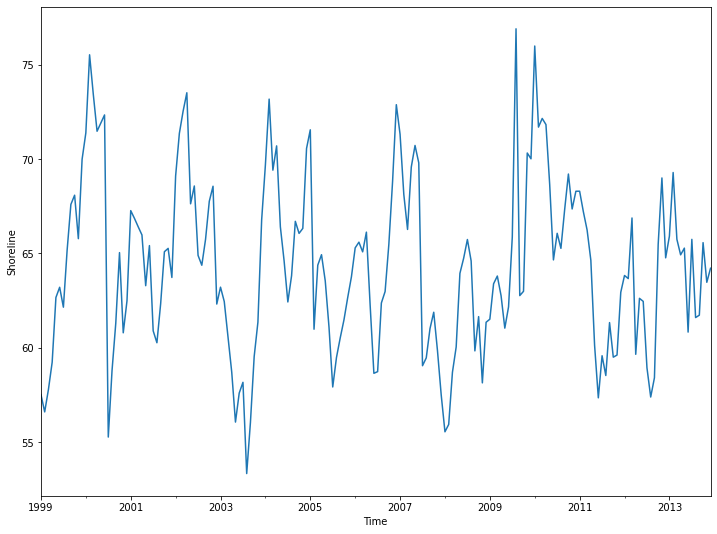

In [5]:
# Making a time plot
with mpl.rc_context():  # this context manager help adjust the size of the plot
    mpl.rc("figure", figsize=(12, 9))
    beach_data.plot.line(xlabel="Time", ylabel="Shoreline", legend=False);

In the next step, I will decompose the time series and plot its components, namely, `Trend`, `Seasonal` and `Residual`.

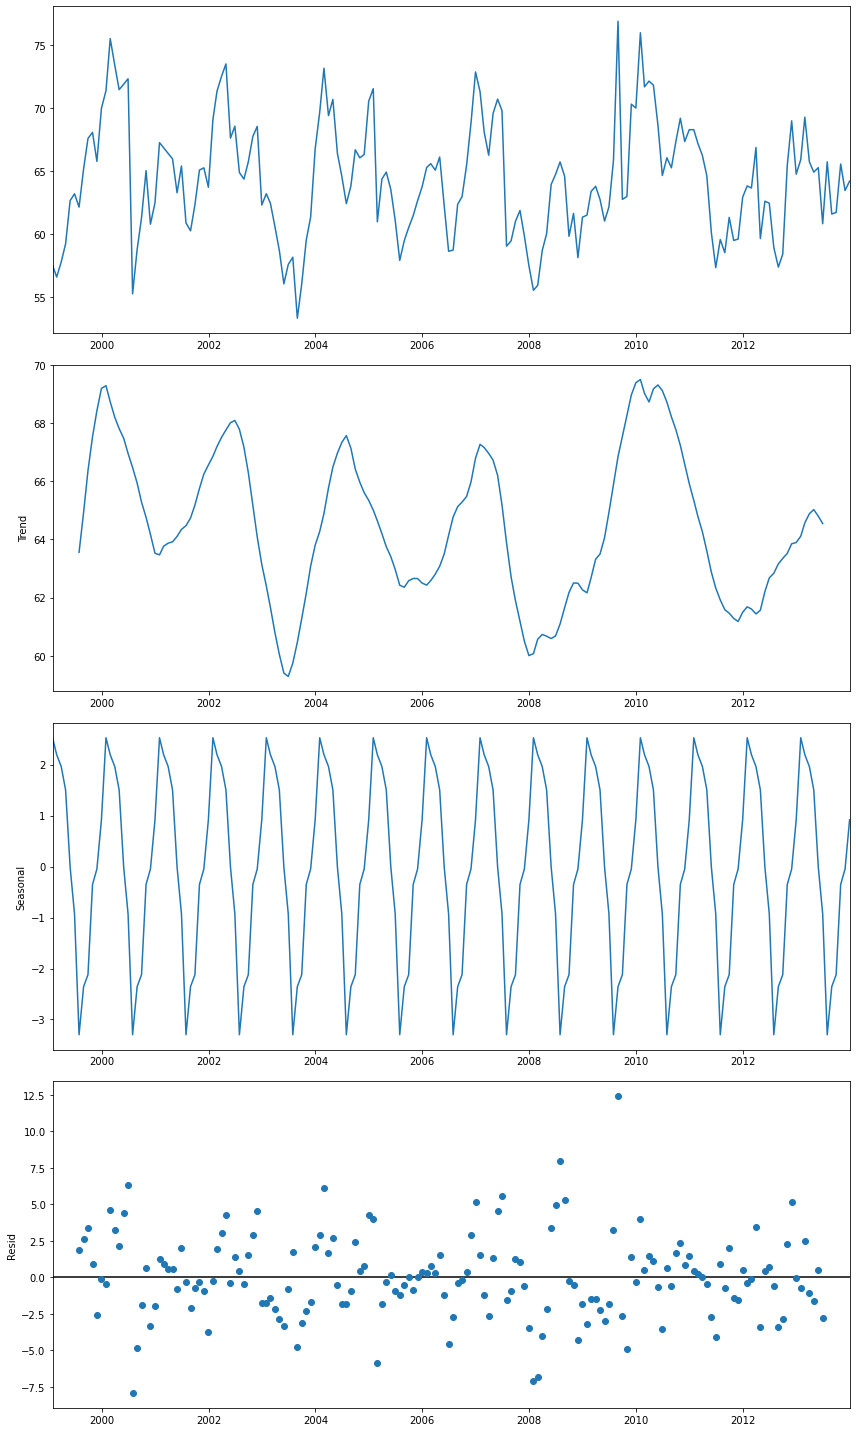

In [6]:
# Decomposing the time series and plotting the components
model = seasonal_decompose(beach_data[["Shoreline"]], model="additive", period=12)
with mpl.rc_context():  # this context manager help adjust the size of the plot
    mpl.rc("figure", figsize=(12, 20))
    model.plot()
    plt.tight_layout()

**Note:** Here, an **additive** classical decomposition would be suitable since based on above plot it seems like the magnitude of the seasonal fluctuations (i.e. the variation around the trend-cycle) does not vary with the value of the series. Also, another proof to this is that there is no **seasonality** in the **Resid component distribution** of the additive decomposition (above plot).

We can also try a multiplicative classical decomposition to see how it looks.

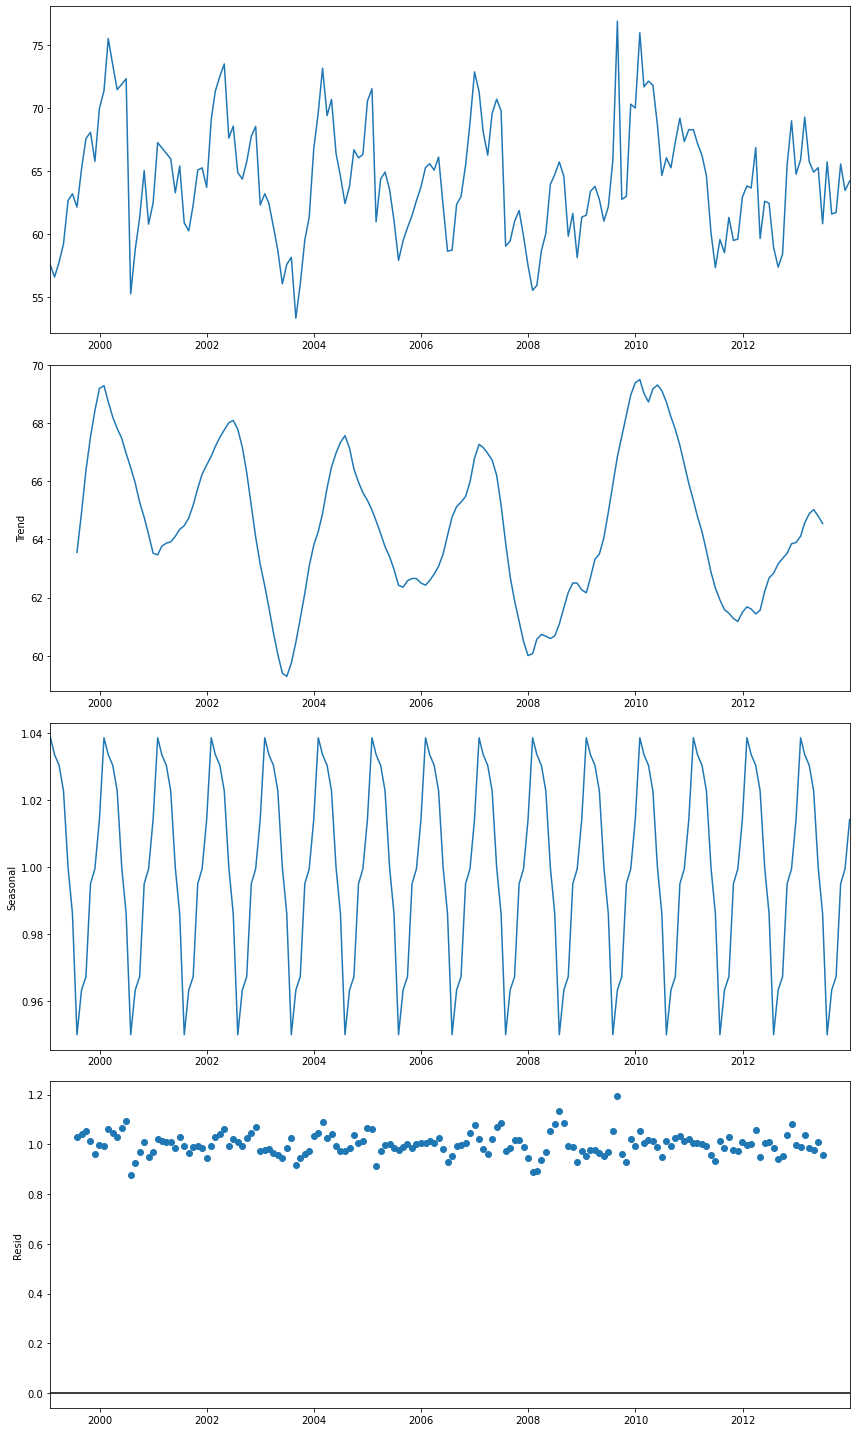

In [7]:
# Multiplicative decomposition of time series and plotting the components
model_mult = seasonal_decompose(beach_data[["Shoreline"]], model="multiplicative", period=12)
with mpl.rc_context():  # this context manager help adjust the size of the plot
    mpl.rc("figure", figsize=(12, 20))
    model_mult.plot()
    plt.tight_layout()

**Note:** Based on the distribution of the Resid component we can see here that an additive decomposition is a better idea, that is why we will continue with that.

## Data Splitting

So, here is the workflow I am following. I will split the `beach-data` into a **train** and **test** splits. I will train the model on the train set and validate it on the test set.


In [8]:
# Splitting the dataset
df_train, df_test = train_test_split(beach_data.dropna(), test_size=0.2, shuffle=False)
df_train = df_train.assign(Label="Train")
df_test = df_test.assign(Label="Test")
df_train.head()

,Shoreline,Label
Time,,
1999-01-31,57.509911,Train
1999-02-28,56.589458,Train
1999-03-31,57.779581,Train
1999-04-30,59.224900,Train
1999-05-31,62.658231,Train


## Modeling

In this section, will build a total of 4 models, namely: `Naive`, `ETS`, `ARIMA` and `SARIMA` and make forecasts.

In [9]:
# Seasonally-adjusted Naive
naive_model = seasonal_decompose(df_train["Shoreline"], model="mult", period=12)
naive_adj = pd.DataFrame({"Shoreline": (df_train["Shoreline"] / naive_model.seasonal).iloc[-1],
                          "Label": "Adjusted Naive"},
                         index=df_test.index)
naive_adj.head()

,Shoreline,Label
Time,,
2011-01-31,67.545548,Adjusted Naive
2011-02-28,67.545548,Adjusted Naive
2011-03-31,67.545548,Adjusted Naive
2011-04-30,67.545548,Adjusted Naive
2011-05-31,67.545548,Adjusted Naive


In [10]:
# ETS AAM
ets_model = ETSModel(df_train["Shoreline"], error="add", trend="mul", seasonal="add", seasonal_periods=12).fit()
ets_aam = pd.DataFrame({"Shoreline": ets_model.forecast(len(df_test.index)),
                        "Label": "ETS (AAM)"},
                       index=df_test.index)
ets_aam.head()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19526D+00    |proj g|=  1.68176D+00

At iterate    1    f=  3.19428D+00    |proj g|=  2.81575D+00

At iterate    2    f=  3.18134D+00    |proj g|=  9.80701D-01

At iterate    3    f=  3.16902D+00    |proj g|=  9.72932D-01

At iterate    4    f=  3.14746D+00    |proj g|=  2.72387D+00

At iterate    5    f=  3.09822D+00    |proj g|=  4.07575D+00

At iterate    6    f=  3.07680D+00    |proj g|=  3.32926D+00

At iterate    7    f=  3.04814D+00    |proj g|=  1.81027D+00

At iterate    8    f=  3.04066D+00    |proj g|=  3.01740D+00

At iterate    9    f=  3.02077D+00    |proj g|=  7.12011D-01

At iterate   10    f=  3.01951D+00    |proj g|=  7.01403D-01

At iterate   11    f=  3.01586D+00    |proj g|=  3.43701D+00

At iterate   12    f=  3.01027D+00    |proj g|=  1.76404D+00

At iterate   13    f=  2.9

,Shoreline,Label
Time,,
2011-01-31,70.192678,ETS (AAM)
2011-02-28,69.490287,ETS (AAM)
2011-03-31,69.342491,ETS (AAM)
2011-04-30,69.638561,ETS (AAM)
2011-05-31,68.169333,ETS (AAM)


In [11]:
# ARIMA
arima_model = ARIMA(df_train["Shoreline"], order=(0, 0, 1)).fit()

arima = pd.DataFrame({"Shoreline": pd.concat((arima_model.fittedvalues, arima_model.forecast(len(df_test.index)))),
                   "Label": "ARIMA"},
                  index=df_test.index).iloc[1:]
arima.tail()

,Shoreline,Label
Time,,
2013-08-31,64.658067,ARIMA
2013-09-30,64.658067,ARIMA
2013-10-31,64.658067,ARIMA
2013-11-30,64.658067,ARIMA
2013-12-31,64.658067,ARIMA


In [12]:
# SARIMA
sarima_model = ARIMA(df_train["Shoreline"], order=(0, 0, 1), seasonal_order=(1, 1, 1, 12)).fit()

sarima = pd.DataFrame({"Shoreline": sarima_model.forecast(len(df_test.index)),
                                "Label": "SARIMA"},
                               index=df_test.index)
sarima.head()

,Shoreline,Label
Time,,
2011-01-31,66.237370,SARIMA
2011-02-28,64.895264,SARIMA
2011-03-31,64.715538,SARIMA
2011-04-30,65.215324,SARIMA
2011-05-31,64.126363,SARIMA


In [13]:
# Plotting the validation data and all forecasts
px.line(pd.concat((df_train, df_test,naive_adj, ets_aam, arima, sarima)), y="Shoreline", width=950, color="Label")

## Model Evaluation

Now, let's quantify the performance of each model. For this, I will first define **Symmetric mean absolute percentage error (sMAPE)** and **Mean_absolute_scaled_error (MASE)** helper functions as below. These metrics are inspired by the paper by [Makridakis et al.](https://www.sciencedirect.com/science/article/pii/S0169207019301128#!).

In [14]:
# Defining Symmetric mean absolute percentage error (sMAPE) function
def smape(y_true, y_pred, y_train):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [15]:
# Defining Mean_absolute_scaled_error function
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    res = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(res / scale))

Next, I will define another helper function, `accuracy()` as below which will return `sMAPE` and `MASE` and the arithmatic average of these two metrics. This will give a more detailed summary of the metrics.

In [16]:
# Defining accuracy() function
def accuracy(y_pred, y_test, y_train):
    """Calculate forecast accuracy.

    Parameters
    ----------
    y_pred : pandas.Series
        Predictions of y_test.
    y_test : pandas.Series
        Test observations.
    y_train : pandas.Series
        Train observations. Required for MASE.
    index : str, optional
        Name of output dataframe index.
        By default = "Results".

    Returns
    -------
    pandas.DataFrame
        A dataframe of the following metrics: MAE,
        RMSE, MAPE, MASE.
    """
    s_mape = smape(y_test, y_pred, y_train)
    mase = mean_absolute_scaled_error(y_test, y_pred, y_train)
    average = (s_mape + mase)/2
    return {"SMAPE": s_mape, "MASE": mase, "AVERAGE": average}

Here are the results:

In [17]:
# Creating sMAPE and MASE dataframe for the models
results = {}
results["Seasonally Adjusted Naive"] = accuracy(df_test["Shoreline"], naive_adj["Shoreline"],  df_train["Shoreline"])
results["ETS AAM"] = accuracy(df_test["Shoreline"], ets_aam["Shoreline"], df_train["Shoreline"])
results["ARIMA"] = accuracy(df_test["Shoreline"], arima["Shoreline"],  df_train["Shoreline"])
results["SARIMA"] = accuracy(df_test["Shoreline"], sarima["Shoreline"],  df_train["Shoreline"])
pd.DataFrame(results).T

,SMAPE,MASE,AVERAGE
Seasonally Adjusted Naive,7.214836,1.861753,4.538294
ETS AAM,8.102125,2.111387,5.106756
ARIMA,4.615272,1.166091,2.890682
SARIMA,3.959479,1.002012,2.480746


**Note:** So far and based on above results, `SARIMA` model has the best performance.

## Machine Learning Modeling

In this section, I will build a `RandomForest` ML model. Before, I will define a function `lag_df` that will add `n` lagged columns to any dataframe.

In [18]:
# Thanks Tom Beuzen for the idea
def lag_df(df, lag=1, cols=None):
    """Add lagged columns to dataframe.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to add lagged columns to.
    lag : int, optional
        Number of lagged values to add, by default = 1.
    cols : list, optional
        Columns to lag, by default all columns in df.

    Returns
    -------
    pd.DataFrame
        DataFrame appended with lagged columns.

    Examples
    --------
    >>> pd.DataFrame({'col': [1, 2]})
    >>> lag_df(df, 3)
       col  col-1  col-2  col-3
    0    1    NaN    NaN    NaN
    1    2    1.0    NaN    NaN
    2    3    2.0    1.0    NaN
    3    4    3.0    2.0    1.0
    """
    if cols is None:
        cols = df.columns
    return df.assign(
        **{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols}
    )

In [19]:
# Lagging train data
df_train_lag = lag_df(df_train, lag=12, cols=["Shoreline"])
df_train_lag = df_train_lag.dropna()
df_train_lag.head()

,Shoreline,Label,Shoreline-1,Shoreline-2,Shoreline-3,Shoreline-4,Shoreline-5,Shoreline-6,Shoreline-7,Shoreline-8,Shoreline-9,Shoreline-10,Shoreline-11,Shoreline-12
Time,,,,,,,,,,,,,,
2000-01-31,71.391011,Train,69.990285,65.778950,68.084581,67.596250,65.174758,62.144774,63.201383,62.658231,59.224900,57.779581,56.589458,57.509911
2000-02-29,75.532977,Train,71.391011,69.990285,65.778950,68.084581,67.596250,65.174758,62.144774,63.201383,62.658231,59.224900,57.779581,56.589458
2000-03-31,73.422839,Train,75.532977,71.391011,69.990285,65.778950,68.084581,67.596250,65.174758,62.144774,63.201383,62.658231,59.224900,57.779581
2000-04-30,71.477156,Train,73.422839,75.532977,71.391011,69.990285,65.778950,68.084581,67.596250,65.174758,62.144774,63.201383,62.658231,59.224900
2000-05-31,71.906199,Train,71.477156,73.422839,75.532977,71.391011,69.990285,65.778950,68.084581,67.596250,65.174758,62.144774,63.201383,62.658231


I will use `recursive` forecasting for the ML model here. In the `recursive` approach, as we forecast into the future, the prediction at time `t` will become an input to our model for predicting at time `t+1` and so on and so forth.

The `recursive_forecast()` function defined below will do the job.

In [20]:
# Thanks Tom Beuzen for the idea
def recursive_forecast(input_data, model, n=20, responses=1):
    forecast = np.empty((n, responses))  # where we'll store our forecasts
    for i, n in enumerate(range(n)):     # loop for making forecasts one at a time
        forecast[i] = model.predict(input_data.reshape(1, -1))  # model forecast
        input_data = np.append(forecast[i], input_data[:-responses])  # append forecast to input data for next forecast
    return forecast.reshape((-1, responses))

In [21]:
# Splitting data to X_train_lag and y_train_lag
X_train_lag = df_train_lag.drop(columns=["Shoreline", "Label"])
y_train_lag = df_train_lag["Shoreline"]

Below, I will define another helper function `mean_absolute_percentage_error` (MAPE). I will use the MAPE function in Hyperparameter Optimization with `RandomForest` to get the best hyperparameters with the model.

In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
# Hyperparameter optimization with RandomForest
optimum_model = {"mape": np.inf}
for n_estimators in [50, 100, 150, 200, 250]:
    for max_depth in [5, 10, 15, 20, 25]:
        RF_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth).fit(X_train_lag, y_train_lag)
        predictions = recursive_forecast(X_train_lag.iloc[-1].to_numpy(), RF_model, n=len(df_test.index)+1).ravel()[1:]
        mape = mean_absolute_percentage_error(df_test["Shoreline"], predictions)
        if mape < optimum_model["mape"]:
            optimum_model["mape"] = mape
            optimum_model["n_estimators"] = n_estimators
            optimum_model["max_depth"] = max_depth
            
optimum_model

{'mape': 7.005434466270007, 'n_estimators': 50, 'max_depth': 25}

In [24]:
# Building Optimized RandomForestRegressor model with Recursive forecast
RF_model = RandomForestRegressor(n_estimators=optimum_model['n_estimators'], max_depth=optimum_model['max_depth']).fit(X_train_lag, y_train_lag)

# Recursive forecast
recursive = pd.DataFrame({"Shoreline": recursive_forecast(X_train_lag.iloc[-1].to_numpy(), RF_model, n=len(df_test.index)+1).ravel()[1:],
                          "Label": "RF Recursive"},
                          index=df_test.index)
recursive.head()

,Shoreline,Label
Time,,
2011-01-31,66.667223,RF Recursive
2011-02-28,66.337591,RF Recursive
2011-03-31,66.605384,RF Recursive
2011-04-30,66.469759,RF Recursive
2011-05-31,67.033854,RF Recursive


Since, `SARIMA` model from previous section had the best performance, let's compare it with the recent `RandomForest` model here.

In [25]:
# Plotting the validation data and SARIMA and RF Recursive forecasts
px.line(pd.concat((df_train, df_test, sarima, recursive)), y="Shoreline", width=950, color="Label")

**Note:** Based on above plot, it seems like `SARIMA` model still beats optimized Recursive `RandomForest` model.


**Conclusion:** I will continue with `SARIMA` model as the best model.

## Test Data

Let's first read in the test split.

In [26]:
# Loading the test data
test_data = pd.read_csv("../input/testdata/beach-test.csv" , index_col = 0, parse_dates = True)
test_data.head()

,Shoreline
Time,
2014-01-31,66.228155
2014-02-28,65.707709
2014-03-31,66.080953
2014-04-30,65.515402
2014-05-31,64.175637


Here, I will add a label to the `test_data`.

In [27]:
test_data['Label'] = 'True Observations'
test_data.head()

,Shoreline,Label
Time,,
2014-01-31,66.228155,True Observations
2014-02-28,65.707709,True Observations
2014-03-31,66.080953,True Observations
2014-04-30,65.515402,True Observations
2014-05-31,64.175637,True Observations


Below, I will define another helper function `create_forecast_index()` which returns a list of **DateTime** index given a starting point and a horizon.

In [28]:
# Defining create_forecast_index() function
def create_forecast_index(start, horizon=30, freq="M"):
    return pd.date_range(start + pd.tseries.frequencies.to_offset(freq), periods=horizon, freq=freq, name="Time")

forecast_index = create_forecast_index(beach_data.index[-1], 36)

Below, is the forecast of the `SARIMA` model on the test data time range.

In [29]:
# Final SARIMA model
model_sarima_final = ARIMA(beach_data["Shoreline"], order=(0, 0, 1), seasonal_order=(1, 1, 1, 12)).fit()
sarima_forecast = pd.DataFrame({"Shoreline": model_sarima_final.forecast(len(test_data.index))},
                               index = forecast_index).assign(Label= "Forecast")
sarima_forecast.head()

,Shoreline,Label
Time,,
2014-01-31,66.228156,Forecast
2014-02-28,65.707713,Forecast
2014-03-31,66.080951,Forecast
2014-04-30,65.515420,Forecast
2014-05-31,64.175646,Forecast


In [30]:
# Final plotting 
px.line(pd.concat((df_train, df_test, naive_adj, ets_aam, arima, recursive, sarima, sarima_forecast, test_data)),
        y="Shoreline", width=950, color="Label")

Above plot shows how forecasts are close to true observations so that the lines are not practically distinguishable.

## Writing the Forecasts

I will write the forecast values into a `.csv` file here for the record.

In [31]:
sarima_forecast.drop("Label", axis='columns', inplace=True)
sarima_forecast.to_csv("forecasts.csv", index=False)

## Conclusions

- Several models including (`Adjusted naive`, `ETS (AAM)`, `ARIMA`, `SARIMA`, `RandomForest`) were built and their performances were evaluated using the 15-year data (1999 - 2013, inclusive) of which `SARIMA` model came out as the winner. 
- `SARIMA` model was used to make predictions for the next 3 years (2014 - 2016, inclusive) where predicted values were compared with the test data (true observations). Results show that the predictions are significantly close to the true observations of those 3 years. 
- There is always room for improvement in this analysis and while building a prefect model is not the intention of this work the main goal is to follow a solid workflow in building a Time-Series model.